# Data Preprocessing

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
import tensorflow as tf
import keras_tuner as kt
from sqlalchemy import create_engine

In [2]:
# connect to database
from config import username, pwd
from db_config import endpoint, port, db_name
db_url = f'postgresql://{username}:{pwd}@{endpoint}:{port}/{db_name}'
engine = create_engine(db_url)
conn = engine.connect()

# read in data to pandas
conflict_df = pd.read_sql_table('conflict_dropped', con = conn)
stocks_df = pd.read_sql_table('joined_stocks', con = conn)

# close connection
conn.close()

In [3]:
# convert strings to datetimes
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])
conflict_df['start_date'] = pd.to_datetime(conflict_df['start_date'])
conflict_df['start_date2'] = pd.to_datetime(conflict_df['start_date2'])

In [4]:
# Trying merge
combined_df = conflict_df.merge(stocks_df, how = 'outer', left_on='start_date2', right_on = 'Date')

In [5]:
# gather conflict information that is within the stock availability window.
sorted_stock_dates = stocks_df.Date.sort_values()
available_conflicts = (conflict_df.start_date >= sorted_stock_dates[0]) & (conflict_df.start_date <= sorted_stock_dates.iloc[-1] )

In [6]:
conflict_df[available_conflicts]

,location,side_a,side_a_2nd,side_b,side_b_2nd,incompatibility,territory_name,cumulative_intensity,type_of_conflict,start_date,start_date2,ep_end,region
0,India,Government of India,None,GNLA,None,1,Garoland,0,3,1997-05-29,2012-11-15,1,3
1,India,Government of India,None,GNLA,None,1,Garoland,0,3,1997-05-29,2014-07-01,1,3
6,Sudan,Government of Sudan,None,Republic of South Sudan,None,1,Abyei,0,3,2011-05-01,2011-05-19,1,4
7,South Sudan,Government of South Sudan,None,"SSDM/A, SSLM/A",None,2,None,0,3,2011-08-20,2011-08-20,0,4
8,South Sudan,Government of South Sudan,None,SSLM/A,None,2,None,0,3,2011-08-20,2011-08-20,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,Ethiopia,Government of Ethiopia,None,SLM,None,1,Sidamaland,1,3,1981-03-21,1983-03-16,1,4
2491,Myanmar (Burma),Government of Myanmar (Burma),None,MNDAA,None,1,Kokang,0,3,2009-08-27,2009-08-29,1,3
2492,Myanmar (Burma),Government of Myanmar (Burma),None,MNDAA,None,1,Kokang,0,3,2009-08-27,2014-12-22,0,3
2493,Myanmar (Burma),Government of Myanmar (Burma),None,MNDAA,None,1,Kokang,0,3,2009-08-27,2014-12-22,1,3


In [7]:
# create a function to identify the nearest date to get relevant stock rows
def find_nearest_date(date, stock_dates, row_list, not_used_index):
    index = stock_dates.index.get_loc(date, method = 'nearest')
    row_list.append(index)
    if index in not_used_index:
        not_used_index.remove(index)
    return row_list, not_used_index

In [8]:
# create stock_dates_df which has ordered dates as the index for searching
stock_dates_df = stocks_df.set_index('Date').sort_index().dropna()

In [9]:
# create a new DF to append stock data to
available_conflicts_df = conflict_df[available_conflicts].copy()
available_conflicts_df[stock_dates_df.columns] = -999 # default value for easy identification

In [10]:
# create lists for storing stock row indices
stock_rows = []
double_count_index = list(range(stock_dates_df.shape[0])) # used to avoid double counting when merging data later

for index, date in available_conflicts_df.start_date2.iteritems():
    stock_rows, double_count_index = \
    find_nearest_date(date, stock_dates_df, stock_rows, double_count_index)

In [11]:
# insert stock data to available_conflicts_df
available_conflicts_df[stock_dates_df.columns] = stock_dates_df.iloc[stock_rows].values

In [12]:
available_conflicts_df

,location,side_a,side_a_2nd,side_b,side_b_2nd,incompatibility,territory_name,cumulative_intensity,type_of_conflict,start_date,start_date2,ep_end,region,S&P_500,NASDAQ,Dow_Jones
0,India,Government of India,None,GNLA,None,1,Garoland,0,3,1997-05-29,2012-11-15,1,3,1359.88,2853.13,12588.31
1,India,Government of India,None,GNLA,None,1,Garoland,0,3,1997-05-29,2014-07-01,1,3,1985.44,4485.93,17068.26
6,Sudan,Government of Sudan,None,Republic of South Sudan,None,1,Abyei,0,3,2011-05-01,2011-05-19,1,4,1333.27,2803.32,12512.04
7,South Sudan,Government of South Sudan,None,"SSDM/A, SSLM/A",None,2,None,0,3,2011-08-20,2011-08-20,0,4,1123.53,2341.84,10817.65
8,South Sudan,Government of South Sudan,None,SSLM/A,None,2,None,0,3,2011-08-20,2011-08-20,0,4,1123.53,2341.84,10817.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,Ethiopia,Government of Ethiopia,None,SLM,None,1,Sidamaland,1,3,1981-03-21,1983-03-16,1,4,149.90,265.01,1117.74
2491,Myanmar (Burma),Government of Myanmar (Burma),None,MNDAA,None,1,Kokang,0,3,2009-08-27,2009-08-29,1,3,1028.93,2028.77,9544.20
2492,Myanmar (Burma),Government of Myanmar (Burma),None,MNDAA,None,1,Kokang,0,3,2009-08-27,2014-12-22,0,3,2070.65,4765.38,17804.80
2493,Myanmar (Burma),Government of Myanmar (Burma),None,MNDAA,None,1,Kokang,0,3,2009-08-27,2014-12-22,1,3,2070.65,4765.38,17804.80


In [13]:
available_conflicts_df[['location',
                        'side_a',
                        'side_b',
                        'territory_name',
                        'start_date',
                        'start_date2',
                        'region',
                        'type_of_conflict',
                        'S&P_500',
                        'NASDAQ',
                        'Dow_Jones']].to_csv('Resources/geo_conflict_data.csv')

In [14]:
# create a function to bin the categorical data
def create_bins(df, col, thresh):
    output = df[col].copy()
    frequencies = output.value_counts()
    categories_to_keep = frequencies[:thresh].index
    output = output.apply(lambda x: x if x in categories_to_keep else 'Other')
    return output

In [15]:
available_conflicts_df.dtypes[available_conflicts_df.dtypes == 'object'].index

Index(['location', 'side_a', 'side_a_2nd', 'side_b', 'side_b_2nd',
       'territory_name', 'region'],
      dtype='object')

In [16]:
my_set = set()
for item in set(available_conflicts_df.side_a_2nd.value_counts().index.to_list()):
    for govt in item.split(', '):
        my_set.add(govt)
len(my_set)
my_set

{'Government of Afghanistan',
 'Government of Angola',
 'Government of Armenia',
 'Government of Australia',
 'Government of Austria',
 'Government of Bangladesh',
 'Government of Belgium',
 'Government of Benin',
 'Government of Bhutan',
 'Government of Bosnia-Herzegovina',
 'Government of Botswana',
 'Government of Burkina Faso',
 'Government of Burundi',
 'Government of Cambodia (Kampuchea)',
 'Government of Cameroon',
 'Government of Canada',
 'Government of Chad',
 'Government of China',
 'Government of Congo',
 'Government of Croatia',
 'Government of Cuba',
 'Government of Czech Republic',
 'Government of DR Congo (Zaire)',
 'Government of Denmark',
 'Government of Djibouti',
 'Government of Egypt',
 'Government of El Salvador',
 'Government of Estonia',
 'Government of Ethiopia',
 'Government of Finland',
 'Government of France',
 'Government of Gambia',
 'Government of Germany',
 'Government of Ghana',
 'Government of Greece',
 'Government of Guatemala',
 'Government of Guinea

In [17]:
# get string columns for encoding
string_cols = available_conflicts_df.dtypes[available_conflicts_df.dtypes == 'object'].index
ignore_cols = ['side_a_2nd', 'side_b_2nd', 'region'] # can handle later if necessary
string_cols = string_cols.drop(labels = ignore_cols)

# bin the categorical data 
names_to_keep = 25 # number of bins = names_to_keep + 1
for col in string_cols:
    available_conflicts_df[col] = create_bins(available_conflicts_df, col, names_to_keep)

# hand encode region columns 1,2,3,4,5 before encoding the rest
available_conflicts_df['region_1'] = 0
available_conflicts_df['region_2'] = 0
available_conflicts_df['region_3'] = 0
available_conflicts_df['region_4'] = 0
available_conflicts_df['region_5'] = 0

# store the conflict region strings as a series
conflict_regions = available_conflicts_df.region.copy()

# loop over the conflict_region strings
for row, regions_string in enumerate(conflict_regions):
    
    # split the strings
    regions = regions_string.split(',')
    # extract the row
    row_data = available_conflicts_df.iloc[row,-5:].copy()
    for region in regions:
        row_data['region_' + str(int(region))] = 1
    available_conflicts_df.iloc[row, -5:] = row_data
available_conflicts_df
# encode the data
binned_df = pd.get_dummies(available_conflicts_df, columns = string_cols)

# add a Date column to binned_df for merging
binned_df['Date'] = binned_df.start_date2

In [18]:
# merge on date and stock data
combined_df = binned_df.merge(
    stock_dates_df.iloc[double_count_index],
    on=['Date', 'S&P_500','NASDAQ','Dow_Jones'],
    how = 'outer'
)

# create year, month, day columns
combined_df['year'] = combined_df.Date.apply(lambda date: date.year)
combined_df['month'] = combined_df.Date.apply(lambda date: date.month)
combined_df['day'] = combined_df.Date.apply(lambda date: date.day)

In [19]:
# drop rows that have missing stock data
combined_df = combined_df[combined_df['S&P_500'].notna()]
combined_df = combined_df[combined_df['NASDAQ'].notna()]
combined_df = combined_df[combined_df['Dow_Jones'].notna()]

In [20]:
# drop start_date and start_date2
combined_df = combined_df.drop(columns = ['start_date', 'start_date2'])

# fill in NaNs
combined_df = combined_df.fillna(0)

In [21]:
# output csv file
output_path = os.path.join('Resources', 'combined_data_1.csv')
combined_df.to_csv(output_path, index = False)

# Starting ML

In [22]:
# drop unnecessary columns from data
ignore_cols.append('Date')
data = combined_df.drop(columns = ignore_cols).drop_duplicates()
data

,incompatibility,cumulative_intensity,type_of_conflict,ep_end,S&P_500,NASDAQ,Dow_Jones,region_1,region_2,region_3,...,territory_name_Novorossiya,territory_name_Other,territory_name_Punjab/Khalistan,territory_name_Rojava Kurdistan,territory_name_Serb,territory_name_Southern Lebanon,territory_name_Tripura,year,month,day
0,1.0,0.0,3.0,1.0,1359.88,2853.13,12588.31,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2012,11,15
1,1.0,0.0,3.0,1.0,1985.44,4485.93,17068.26,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2014,7,1
2,1.0,0.0,3.0,1.0,1333.27,2803.32,12512.04,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2011,5,19
3,2.0,0.0,3.0,0.0,1123.53,2341.84,10817.65,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2011,8,20
5,2.0,1.0,3.0,0.0,1123.53,2341.84,10817.65,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2011,8,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2592,0.0,0.0,0.0,0.0,2423.41,6140.42,21349.63,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,6,30
2593,0.0,0.0,0.0,0.0,2472.54,6387.75,21580.07,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,7,21
2594,0.0,0.0,0.0,0.0,2472.10,6374.68,21830.31,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,7,28
2595,0.0,0.0,0.0,0.0,2441.32,6256.56,21858.32,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,8,11


In [23]:
# extract X and y from data
y_cols = ['S&P_500', 'NASDAQ', 'Dow_Jones']
X = data.drop(columns = y_cols)
# converts all column dtypes to string instead of some being sqlalchemy quoted_name
X.columns = X.columns.map(str)
y = data[y_cols]

In [24]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size=.8)

In [25]:
# scale data
X_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [32]:
X[X.year == 2001]

,incompatibility,cumulative_intensity,type_of_conflict,ep_end,region_1,region_2,region_3,region_4,region_5,location_Algeria,...,territory_name_Novorossiya,territory_name_Other,territory_name_Punjab/Khalistan,territory_name_Rojava Kurdistan,territory_name_Serb,territory_name_Southern Lebanon,territory_name_Tripura,year,month,day
295,2.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2001,5,12
296,2.0,1.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2001,5,12
496,2.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2001,6,1
497,2.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2001,6,1
521,2.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2001,9,11
537,2.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2001,9,11
581,2.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2001,10,7
660,2.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2001,5,3
683,1.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2001,8,4
686,1.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2001,8,4


## Extra Random Trees Regressor

In [33]:
# create regressor
# n_jobs = -1 means use all the processors on your PC to compute the decision trees in parallel
erf = ExtraTreesRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)

# fit regressor/train model
erf.fit(X_train_scaled, y_train)

# make predictions
y_pred = erf.predict(X_test_scaled)

# covert predictions into dataframe
y_pred_df = pd.DataFrame(y_pred.round(2), index = y_test.index, columns = y_test.columns)

In [34]:
mean_squared_error(y_test, y_pred_df, squared=False, multioutput='raw_values')

array([ 22.02850271,  68.77912573, 189.16334372])

In [35]:
r2_score(y_test, y_pred_df)

0.9984806609129172

In [36]:
(((np.abs(y_test-y_pred_df) / y_test) * 100)).max()

S&P_500      22.906249
NASDAQ       35.344431
Dow_Jones    19.303284
dtype: float64

In [37]:
for importance, feature in sorted(zip(erf.feature_importances_, X.columns), reverse=True):
    print(feature, importance)

year 0.9756062910119059
territory_name_Islamic State 0.009155322168726167
month 0.006580653286561413
side_b_IS 0.0063633516866222085
day 0.000586633244976317
type_of_conflict 0.00031497476012634575
cumulative_intensity 0.00012355802711623
incompatibility 0.00011062994633272095
region_2 9.597059992079662e-05
region_4 7.989392371598975e-05
location_Pakistan 7.984265410978841e-05
side_a_Government of Pakistan 7.039532616095372e-05
side_b_FDLR 5.387952451175048e-05
side_b_Other 4.3877885452193724e-05
side_a_Government of Rwanda 4.138589595800367e-05
side_a_Government of South Sudan 3.971659872509006e-05
location_Syria 3.8835011501314166e-05
territory_name_Other 3.81461671288264e-05
location_Egypt 3.6874184826611745e-05
side_a_Government of Syria 3.6602136008178745e-05
region_1 3.2984996143508184e-05
region_3 3.187820292944761e-05
location_South Sudan 2.940457416019084e-05
side_a_Government of Russia (Soviet Union) 2.7714512716430746e-05
ep_end 2.6509492076010056e-05
location_Rwanda 2.54087

## Case: September 11th, 2001

In [191]:
from datetime import datetime, timedelta
incident_date = datetime.strptime('2001-09-11', '%Y-%m-%d')
X_sept = X.copy()
X_sept['date'] = pd.to_datetime(X_sept[['year', 'month', 'day']])
X_sept = X_sept[X_sept.date <= incident_date]
X_sept = X_sept.drop('date')

,incompatibility,cumulative_intensity,type_of_conflict,ep_end,region_1,region_2,region_3,region_4,region_5,location_Algeria,...,territory_name_Other,territory_name_Punjab/Khalistan,territory_name_Rojava Kurdistan,territory_name_Serb,territory_name_Southern Lebanon,territory_name_Tripura,year,month,day,date
13,1.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1978,11,15,1978-11-15
14,2.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1979,12,27,1979-12-27
15,2.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1981,7,30,1981-07-30
50,1.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1991,10,10,1991-10-10
51,1.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1991,12,31,1991-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2001,7,27,2001-07-27
1861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2001,8,10,2001-08-10
1862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2001,8,17,2001-08-17
1863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2001,8,24,2001-08-24


In [ ]:
# scale data
X_sept_scaler = StandardScaler()

X_sept_scaled = X_sept_scaler.fit_transform(X_sept)
X_sept_scaled = X_sept_scaler.transform(data_window_df)

In [ ]:
# create regressor
# n_jobs = -1 means use all the processors on your PC to compute the decision trees in parallel
erf_sept = ExtraTreesRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)

# fit regressor/train model
erf_sept.fit(X_train_scaled, y_train)

# make predictions
y_pred = erf.predict(X_test_scaled)

# covert predictions into dataframe
y_pred_df = pd.DataFrame(y_pred.round(2), index = y_test.index, columns = y_test.columns)

In [170]:
september_data_df = X[(X.year == 2001) & (X.month == 9)]

data_window_df = X[(X.year == 2001)]

no_conflict_df = september_data_df.iloc[[2]]
conflict_df = september_data_df.iloc[[0]]


In [171]:
dates_df = pd.to_datetime(data_window_df.loc[:,('year','month','day')])
data_window_df.loc[:,'date'] = dates_df
start_date = datetime.strptime('2001-07-19','%Y-%m-%d')
end_date = datetime.strptime('2001-12-09', '%Y-%m-%d')
data_window_df = data_window_df[(data_window_df.date >= start_date) & (data_window_df.date <= end_date)]
list_of_dates = pd.date_range(start = start_date, end = end_date, freq = 'd', normalize = True)

C:\Users\longs\anaconda3\envs\mlenv\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [173]:
dates_df_list = []
for date in list_of_dates:
    date_in_frame_index = (data_window_df.date == date)
    date_in_frame = date_in_frame_index.any()
    if date_in_frame:
        df = data_window_df[date_in_frame_index].iloc[[0]].copy()
    else:
        df = no_conflict_df.copy()
    df.month, df.day = date.month, date.day
    df['date'] = date
    dates_df_list.append(df)

In [174]:
X_september = pd.concat(dates_df_list, ignore_index = True)
X_september_scaled = X_scaler.transform(X_september.drop(columns = ['date']))
y_september_pred = erf.predict(X_september_scaled)

In [177]:
X_september

,incompatibility,cumulative_intensity,type_of_conflict,ep_end,region_1,region_2,region_3,region_4,region_5,location_Algeria,...,territory_name_Other,territory_name_Punjab/Khalistan,territory_name_Rojava Kurdistan,territory_name_Serb,territory_name_Southern Lebanon,territory_name_Tripura,year,month,day,date
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2001,7,19,2001-07-19
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2001,7,20,2001-07-20
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2001,7,21,2001-07-21
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2001,7,22,2001-07-22
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2001,7,23,2001-07-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2001,12,5,2001-12-05
140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2001,12,6,2001-12-06
141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2001,12,7,2001-12-07
142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2001,12,8,2001-12-08


In [178]:
y_september_pred_df

,S&P_500,NASDAQ,Dow_Jones,date
date,,,,
2001-07-19,1213.25,2041.63,10585.14,2001-07-19
2001-07-20,1210.85,2029.37,10576.65,2001-07-20
2001-07-21,1207.24,2022.27,10528.12,2001-07-21
2001-07-22,1208.02,2027.37,10512.05,2001-07-22
2001-07-23,1207.52,2027.30,10492.47,2001-07-23
...,...,...,...,...
2001-12-05,1108.80,1845.66,9579.13,2001-12-05
2001-12-06,1113.47,1858.50,9620.99,2001-12-06
2001-12-07,1115.54,1867.20,9644.15,2001-12-07


<AxesSubplot:xlabel='date', ylabel='S&P_500'>

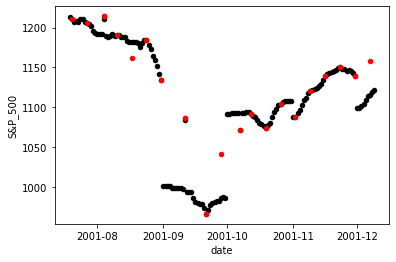

In [176]:
y_september_pred_df = pd.DataFrame(y_september_pred.round(2),index= X_september.date, columns = y_test.columns)
y_september_pred_df['date'] = y_september_pred_df.index
ax = y_september_pred_df.plot(x = 'date', y = 'S&P_500', kind = 'scatter', color = 'black')
y_september_df = y.loc[data_window_df.index.to_list()]
y_september_df['date'] = data_window_df.date
y_september_df.plot(ax = ax, x = 'date', y = 'S&P_500', kind = 'scatter', c = 'red')

In [169]:
y_september_pred_df.drop(columns = 'date').to_csv('Resources/september_11_predicted.csv')

## Neural Network

In [211]:
nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Dense(units = 200, activation = 'relu'))
nn.add(tf.keras.layers.Dropout(0.2))
nn.add(tf.keras.layers.Dense(units = 100, activation = 'relu'))
nn.add(tf.keras.layers.Dense(units = 3, activation = 'linear'))

In [215]:
nn.compile(
    loss = tf.keras.losses.mae,
    optimizer = tf.keras.optimizers.SGD(),
    metrics = ['mae']
)
nn.fit(X_train_scaled, y_train, epochs = 1000)

Epoch 1/1000
57/57 [==============================] - 0s 1ms/step - loss: 551.8988 - mae: 551.8988
Epoch 2/1000
57/57 [==============================] - 0s 980us/step - loss: 582.0170 - mae: 582.0170
Epoch 3/1000
57/57 [==============================] - 0s 962us/step - loss: 573.0860 - mae: 573.0860
Epoch 4/1000
57/57 [==============================] - 0s 1ms/step - loss: 548.7827 - mae: 548.7827
Epoch 5/1000
57/57 [==============================] - 0s 997us/step - loss: 527.3619 - mae: 527.3619
Epoch 6/1000
57/57 [==============================] - 0s 1ms/step - loss: 556.2410 - mae: 556.2410
Epoch 7/1000
57/57 [==============================] - 0s 1ms/step - loss: 558.3566 - mae: 558.3566
Epoch 8/1000
57/57 [==============================] - 0s 1ms/step - loss: 559.9661 - mae: 559.9661
Epoch 9/1000
57/57 [==============================] - 0s 1ms/step - loss: 559.1904 - mae: 559.1904
Epoch 10/1000
57/57 [==============================] - 0s 1ms/step - loss: 570.9918 - mae: 570.9918
Epo

57/57 [==============================] - 0s 997us/step - loss: 401.9263 - mae: 401.9263
Epoch 164/1000
57/57 [==============================] - 0s 1ms/step - loss: 391.6384 - mae: 391.6384
Epoch 165/1000
57/57 [==============================] - 0s 1ms/step - loss: 406.8099 - mae: 406.8099
Epoch 166/1000
57/57 [==============================] - 0s 1ms/step - loss: 407.2310 - mae: 407.2310
Epoch 167/1000
57/57 [==============================] - 0s 997us/step - loss: 389.8947 - mae: 389.8947
Epoch 168/1000
57/57 [==============================] - 0s 997us/step - loss: 414.6243 - mae: 414.6243
Epoch 169/1000
57/57 [==============================] - 0s 989us/step - loss: 384.5323 - mae: 384.5323
Epoch 170/1000
57/57 [==============================] - 0s 1ms/step - loss: 397.8990 - mae: 397.8990
Epoch 171/1000
57/57 [==============================] - 0s 961us/step - loss: 378.1489 - mae: 378.1489
Epoch 172/1000
57/57 [==============================] - 0s 962us/step - loss: 392.1364 - mae: 39

57/57 [==============================] - 0s 1ms/step - loss: 366.7778 - mae: 366.7778
Epoch 244/1000
57/57 [==============================] - 0s 1ms/step - loss: 379.3662 - mae: 379.3662
Epoch 245/1000
57/57 [==============================] - 0s 1ms/step - loss: 359.6300 - mae: 359.6300
Epoch 246/1000
57/57 [==============================] - 0s 1ms/step - loss: 372.8210 - mae: 372.8210
Epoch 247/1000
57/57 [==============================] - 0s 980us/step - loss: 373.5051 - mae: 373.5051
Epoch 248/1000
57/57 [==============================] - 0s 890us/step - loss: 372.8013 - mae: 372.8013
Epoch 249/1000
57/57 [==============================] - 0s 944us/step - loss: 401.9902 - mae: 401.9902
Epoch 250/1000
57/57 [==============================] - 0s 890us/step - loss: 351.6868 - mae: 351.6868
Epoch 251/1000
57/57 [==============================] - 0s 962us/step - loss: 371.9182 - mae: 371.9182
Epoch 252/1000
57/57 [==============================] - 0s 890us/step - loss: 366.2212 - mae: 36

57/57 [==============================] - 0s 980us/step - loss: 367.3344 - mae: 367.3344
Epoch 404/1000
57/57 [==============================] - 0s 944us/step - loss: 342.6454 - mae: 342.6454
Epoch 405/1000
57/57 [==============================] - 0s 980us/step - loss: 381.0044 - mae: 381.0044
Epoch 406/1000
57/57 [==============================] - 0s 944us/step - loss: 340.8581 - mae: 340.8581
Epoch 407/1000
57/57 [==============================] - 0s 980us/step - loss: 363.2480 - mae: 363.2480
Epoch 408/1000
57/57 [==============================] - 0s 997us/step - loss: 343.8938 - mae: 343.8938
Epoch 409/1000
57/57 [==============================] - 0s 1ms/step - loss: 367.4052 - mae: 367.4052
Epoch 410/1000
57/57 [==============================] - 0s 1ms/step - loss: 336.0216 - mae: 336.0216
Epoch 411/1000
57/57 [==============================] - 0s 1ms/step - loss: 345.7981 - mae: 345.7981
Epoch 412/1000
57/57 [==============================] - 0s 944us/step - loss: 355.0934 - mae: 

57/57 [==============================] - 0s 1ms/step - loss: 339.3687 - mae: 339.3687
Epoch 565/1000
57/57 [==============================] - 0s 1ms/step - loss: 337.9182 - mae: 337.9182
Epoch 566/1000
57/57 [==============================] - 0s 1ms/step - loss: 336.4547 - mae: 336.4547
Epoch 567/1000
57/57 [==============================] - 0s 1ms/step - loss: 332.8789 - mae: 332.8789
Epoch 568/1000
57/57 [==============================] - 0s 1ms/step - loss: 339.5019 - mae: 339.5019
Epoch 569/1000
57/57 [==============================] - 0s 1ms/step - loss: 355.5162 - mae: 355.5162
Epoch 570/1000
57/57 [==============================] - 0s 1ms/step - loss: 335.2060 - mae: 335.2060
Epoch 571/1000
57/57 [==============================] - 0s 1ms/step - loss: 360.8268 - mae: 360.8268
Epoch 572/1000
57/57 [==============================] - 0s 1ms/step - loss: 346.9440 - mae: 346.9440
Epoch 573/1000
57/57 [==============================] - 0s 1ms/step - loss: 331.3490 - mae: 331.3490
Epoch

57/57 [==============================] - 0s 1ms/step - loss: 325.1765 - mae: 325.1765
Epoch 727/1000
57/57 [==============================] - 0s 1ms/step - loss: 330.5918 - mae: 330.5918
Epoch 728/1000
57/57 [==============================] - 0s 1ms/step - loss: 345.7897 - mae: 345.7897
Epoch 729/1000
57/57 [==============================] - 0s 1ms/step - loss: 342.6808 - mae: 342.6808
Epoch 730/1000
57/57 [==============================] - 0s 1ms/step - loss: 358.3357 - mae: 358.3357
Epoch 731/1000
57/57 [==============================] - 0s 1ms/step - loss: 351.5790 - mae: 351.5790
Epoch 732/1000
57/57 [==============================] - 0s 1ms/step - loss: 350.1344 - mae: 350.1344
Epoch 733/1000
57/57 [==============================] - 0s 1ms/step - loss: 322.9376 - mae: 322.9376
Epoch 734/1000
57/57 [==============================] - 0s 1ms/step - loss: 317.3528 - mae: 317.3528
Epoch 735/1000
57/57 [==============================] - 0s 1ms/step - loss: 342.2285 - mae: 342.2285
Epoch

57/57 [==============================] - 0s 1ms/step - loss: 325.1674 - mae: 325.1674
Epoch 889/1000
57/57 [==============================] - 0s 1ms/step - loss: 328.6848 - mae: 328.6848
Epoch 890/1000
57/57 [==============================] - 0s 1ms/step - loss: 335.1366 - mae: 335.1366
Epoch 891/1000
57/57 [==============================] - 0s 1ms/step - loss: 331.8321 - mae: 331.8321
Epoch 892/1000
57/57 [==============================] - 0s 1ms/step - loss: 333.8438 - mae: 333.8438
Epoch 893/1000
57/57 [==============================] - 0s 1ms/step - loss: 298.8416 - mae: 298.8416
Epoch 894/1000
57/57 [==============================] - 0s 1ms/step - loss: 313.0220 - mae: 313.0220
Epoch 895/1000
57/57 [==============================] - 0s 1ms/step - loss: 323.5167 - mae: 323.5167
Epoch 896/1000
57/57 [==============================] - 0s 1ms/step - loss: 358.2686 - mae: 358.2686
Epoch 897/1000
57/57 [==============================] - 0s 1ms/step - loss: 341.7364 - mae: 341.7364
Epoch

In [216]:
y_september_pred_nn = nn.predict(X_september_scaled)

<AxesSubplot:xlabel='day', ylabel='S&P_500'>

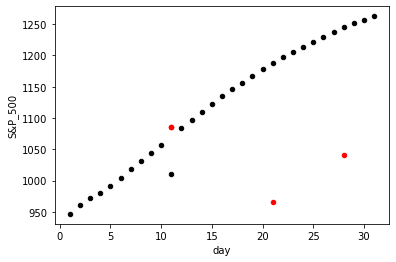

In [217]:
y_september_pred_nn_df = pd.DataFrame(y_september_pred_nn.round(2),index= list(range(1,32)), columns = y_test.columns)
y_september_pred_nn_df['day'] = y_september_pred_nn_df.index
ax = y_september_pred_nn_df.plot(x = 'day', y = 'S&P_500', kind = 'scatter', color = 'black')
y_september_df = y.loc[september_data_df.index.to_list()]
y_september_df['day'] = september_data_df.day
y_september_df.plot(ax = ax, x = 'day', y = 'S&P_500', kind = 'scatter', c = 'red')